In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import pymc as pm
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
db_mon = pd.read_csv('data/mon_clean.csv')
db_med = pd.read_csv('data/med_clean.csv')

print('Participants monetary: ', len(db_mon['sub'].unique()), '\nparticipants medical: ', len(db_med['sub'].unique()))

Participants monetary:  66 
participants medical:  66


In [3]:
# Assign a unique serial number for each participant.
db_mon['subn'] = db_mon['sub'].rank(method='dense').astype(int) - 1

# Count the number of unique subjects in the 'db_mon' dataset.
n_subs = db_mon['subn'].unique().shape[0]

# Create a list of subject indices for all rows in the 'db_mon' dataset.
sub_idx = db_mon.subn.tolist()

# Assign a unique serial number for each participant. This will be useful for indexing operations.
db_med['subn'] = db_med['sub'].rank(method='dense').astype(int) - 1

# Count the number of unique subjects in the 'db_med' dataset.
n_subs_med = db_med['subn'].unique().shape[0]

# Create a list of subject indices for all rows in the 'db_med' dataset.
sub_idx_med = db_med.subn.tolist()

In [4]:
def straw_man(df, n_subs, idx):
    """
    A simple model (straw man) that tries to estimate the influence of value, risk, and ambiguity 
    on the choice made by subjects in a gambling scenario.

    Parameters:
    - df: DataFrame containing data on choice, value, risk, and ambiguity for each trial
    - n_subs: Number of subjects in the study
    - idx: Subject index for each trial (used for hierarchical modeling)

    Returns:
    - trace: Samples from the posterior distribution
    """
    
    with pm.Model() as simple:  # Define a new PyMC3 model
    
        # Define hyperpriors for the group-level parameter (γ)
        gMu = pm.Normal('gMu',  0, 1) # Mean of the normal distribution
        gSig = pm.Gamma('gSig', 2, 1) # Standard deviation (Gamma distribution provides only positive values)

        # Define the subject-specific risk preference (γ) using a lognormal distribution
        γ = pm.Lognormal('γ', gMu, gSig, shape = n_subs)

        # Compute expected value of the lottery outcome
        val  = df['value'].values                                # Values from the 'value' column in the DataFrame
        prob = df['risk'].values - (df['ambiguity'].values / 2)  # Probability calculation adjusted by ambiguity

        svLotto = val * prob # Subjective value of the lottery
        svRef   = 1          # Subjective value of a reference (assumed to be 1)

        # Define the linear predictor (p) and compute the expected probability (mu) using the inverse logit function
        p  = (svLotto - svRef) / γ[idx]
        mu =  pm.invlogit(p)                     # The invlogit function transforms values to the (0,1) interval

        # Define the likelihood of the observed data. A binomial likelihood is chosen because the outcome is binary (choice is 0 or 1)
        choice = pm.Binomial('choice', 1, mu, observed=df['choice'])

        trace = pm.sample(idata_kwargs={'log_likelihood':True})
        
    return(trace)

In [5]:
def Utility(df, n_subs, idx):
    """
    Estimate the utility function of the subjects using a model that accounts for both the value of an outcome 
    and the probability of its occurrence.

    Parameters:
    - df: DataFrame containing data on choice, value levels, risk, and ambiguity for each trial.
    - n_subs: Number of subjects in the dataset.
    - idx: Subject index for each trial (used for modeling individual variations).

    Returns:
    - trace: Samples from the posterior distribution.
    """
    
    # Define the probabilistic model for utility function
    with pm.Model() as Utility:
        
        # Hyperpriors define group-level distributions for subject-specific parameters.
        alpha_a = pm.Normal('alpha_a',  4,   1)  # Shape parameter for risk attitude
        alpha_b = pm.Normal('alpha_b', 7,   3)  # Rate parameter for risk attitude
        bMu     = pm.Normal('bMu',     .65, 1)  # Group-level mean for ambiguity modulation
        bSig    = pm.Gamma('bSig',     4,   1)  # Group-level standard deviation for ambiguity modulation

        # Individual subject priors.
        alpha = pm.Beta('alpha',  alpha_a, alpha_b, shape = n_subs)                        # Subject-specific utility curvature
        α = pm.Deterministic('α', alpha * 2)                                               # Double the value of alpha for further computations
        β = pm.TruncatedNormal('β',  bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs) # Ambiguity modulation
        γ = pm.LogNormal('γ', 0, .25, shape = n_subs)                                   # Inverse temperature parameter

        # Calculate expected value of outcome using a power function.
        value = df['value'].values ** α[idx]  # Subjective value based on curvature parameter
        prob  = df['risk'].values  - (β[idx] * (df['ambiguity'].values/2))  # Probability of outcome considering ambiguity

        # Calculate subjective value (SV) of the lottery for each trial
        svLotto = value * prob
        svRef   = 5 ** α[idx]  # Reference value

        # Convert SV into a probability of choosing the lottery using the inverse logit function.
        p  = (svLotto - svRef) / γ[idx]
        mu = pm.invlogit(p)

        # Define likelihood of observations using a Binomial distribution, as choice is binary.
        choice = pm.Binomial('choice', 1, mu, observed=df['choice'])

        trace = pm.sample(idata_kwargs={'log_likelihood':True})
           
    return(trace)

In [6]:
def Utility_th(df, n_subs, idx):
    """
    Estimate the utility function of the subjects using a model that accounts for both the value of an outcome 
    and the probability of its occurrence, with a modified choice function incorporating tremble hand effect (γ).

    Parameters:
    - df: DataFrame containing data on choice, value levels, risk, and ambiguity for each trial.
    - n_subs: Number of subjects in the dataset.
    - idx: Subject index for each trial (used for modeling individual variations).

    Returns:
    - trace: Samples from the posterior distribution.
    """
    
    # Define the probabilistic model for the utility function
    with pm.Model() as trembel_hand:
        
        # Hyperpriors: Define group-level distributions for subject-specific parameters.
        alpha_a = pm.TruncatedNormal('alpha_a', 4, 1, lower = 1)  # Shape parameter for utility curvature
        alpha_b = pm.TruncatedNormal('alpha_b', 7, 1, lower = 1)  # Rate parameter for utility curvature

        g_a = pm.TruncatedNormal('g_a', 2, 1, lower = 1)  # Shape parameter for tremble hand effect
        g_b = pm.TruncatedNormal('g_b', 2, 1, lower = 1)  # Rate parameter for tremble hand effect

        bMu  = pm.Normal('bMu', .65, .5)  # Mean for ambiguity modulation
        bSig = pm.Gamma('bSig', 2, 1)     # Standard deviation for ambiguity modulation

        # Individual subject priors.
        alpha = pm.Beta('alpha', alpha_a, alpha_b, shape = n_subs)  # Subject-specific utility curvature
        α = pm.Deterministic('α', alpha * 2)  # Double the value of alpha for further computations
        β = pm.TruncatedNormal('β', bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs)  # Ambiguity modulation
        γ = pm.Beta('γ', g_a, g_b, shape = n_subs)  # Tremble hand effect (probability of random choice)

        # Calculate expected value of outcome using a power function.
        value = df['value'].values ** α[idx]
        prob  = df['risk'].values - (β[idx] * (df['ambiguity'].values/2))

        svLotto = value * prob
        svRef   = 5 ** α[idx]
        
        # Convert SV into a modified probability of choosing the lottery using the inverse logit function 
        # and the tremble hand effect.
        p = (1/(1+np.exp(-(svLotto - svRef)))) * (1-γ[idx]) + γ[idx] * .5
        
        # Define likelihood of observations using a Binomial distribution, as choice is binary.
        choice = pm.Binomial('choice', 1, p, observed=df['choice'])

        trace = pm.sample(idata_kwargs={'log_likelihood':True})
        
    return(trace)

In [7]:
def estamte_values_ordinal(df, n_subs, idx):
    """
    Estimate the value of different reward levels using ordinal constraints and a common hyperprior for each level. 
    The model ensures that the levels are positive (ordinal constraints).

    Parameters:
    - df: DataFrame with trial-specific details, such as choices, value levels, risk, and ambiguity levels.
    - n_sub: Total number of subjects in the dataset.
    - idx: A list indicating the subject ID for each observation/trial.

    Returns:
    - trace: Samples from the posterior distribution of the model.
    """
    
    with pm.Model() as estimate:

        # Hyperparameters for group-level distributions
        bMu  = pm.Normal('bMu', .65, 1)     # Mean for ambiguity effect distribution
        bSig = pm.Gamma('bSig', 2, 1)       # SD for ambiguity effect distribution

        # Hyperparameters for group-level subjective value levels
        l1Mu = pm.TruncatedNormal('l1Mu', 4, 2, lower=.1)  # Mean for value of level 1
        l2Mu = pm.TruncatedNormal('l2Mu', 4, 2, lower=.1)  # ... level 2
        l3Mu = pm.TruncatedNormal('l3Mu', 4, 2, lower=.1)  # ... level 3
        l4Mu = pm.TruncatedNormal('l4Mu', 4, 2, lower=.1)  # ... level 4
        
        l1sd = pm.Gamma('l1sd', 3, 1)  # SD for value of level 1
        l2sd = pm.Gamma('l2sd', 3, 1)  # ... level 2
        l3sd = pm.Gamma('l3sd', 3, 1)  # ... level 3
        l4sd = pm.Gamma('l4sd', 3, 1)  # ... level 4
        
        # Subject-specific priors 
        β = pm.Normal('β',    bMu, bSig, shape = n_subs)   # Modulation of ambiguity effect
        γ = pm.Lognormal('γ', 0, 0.25, shape = n_subs)   # Inverse temperature, impacting choice stochasticity

        # Priors for subjective values of the different reward levels for each subject.
        level1 = pm.TruncatedNormal('level1', l1Mu, l1sd, lower = 0, shape = n_subs)
        level2 = pm.TruncatedNormal('level2', l2Mu, l2sd, lower = 0, shape = n_subs)
        level3 = pm.TruncatedNormal('level3', l3Mu, l3sd, lower = 0, shape = n_subs)
        level4 = pm.TruncatedNormal('level4', l4Mu, l4sd, lower = 0, shape = n_subs)

        # Calculate the total expected value for each trial by combining values from different levels
        val = (df['l1'].values * level1[idx] + 
               df['l2'].values * level2[idx] + 
               df['l3'].values * level3[idx] + 
               df['l4'].values * level4[idx]) 

        # Calculate adjusted probability by considering both risk and ambiguity levels modulated by β
        prob = (df['risk'].values) - (β[idx] * (df['ambiguity'].values/2))  

        # Compute the subjective value of the lottery option
        svLotto = val * prob
        svRef   = level1[idx]  # The subjective value of the reference option

        # Transform the SV difference between lottery and reference into a choice probability using the logistic function
        p  = (svLotto - svRef) / γ[idx]
        mu = pm.invlogit(p)

        # Likelihood of the observed choices given the computed probabilities
        choice = pm.Binomial('choice', 1, mu, observed=df['choice'])

        trace = pm.sample(idata_kwargs={'log_likelihood':True})
        
    return trace

In [8]:
mon_simple = straw_man(db_mon, n_subs, sub_idx)
mon_utility = Utility(db_mon, n_subs, sub_idx)
mon_trmbling_hand = Utility_th(db_mon, n_subs, sub_idx)
mon_estimated = estamte_values_ordinal(db_mon, n_subs, sub_idx)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gMu, gSig, γ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_a, alpha_b, bMu, bSig, alpha, β, γ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_a, alpha_b, g_a, g_b, bMu, bSig, alpha, β, γ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 146 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bMu, bSig, l1Mu, l2Mu, l3Mu, l4Mu, l1sd, l2sd, l3sd, l4sd, β, γ, level1, level2, level3, level4]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 111 seconds.


In [9]:
compare_dict = {'simple model':       mon_simple, 
                'Classic Utility':    mon_utility,
                'Trembling-hand':     mon_trmbling_hand, 
                "Ordinal":            mon_estimated,

}

comp = az.compare(compare_dict)
comp

/home/nachshon/anaconda3/envs/pymc5/lib/python3.9/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nachshon/anaconda3/envs/pymc5/lib/python3.9/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nachshon/anaconda3/envs/pymc5/lib/

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Ordinal,0,-1562.715442,225.344406,0.000000,0.957313,45.702861,0.000000,True,log
Classic Utility,1,-1910.163601,142.573116,347.448159,0.000000,42.186540,24.292659,True,log
Trembling-hand,2,-1977.620376,136.719548,414.904933,0.038184,36.575835,29.657217,True,log
simple model,3,-3457.137533,34.046341,1894.422091,0.004503,22.052058,43.778200,False,log


In [10]:
med_simple = straw_man(db_med, n_subs_med, sub_idx_med)
med_estimated = estamte_values_ordinal(db_med, n_subs_med, sub_idx_med)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gMu, gSig, γ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bMu, bSig, l1Mu, l2Mu, l3Mu, l4Mu, l1sd, l2sd, l3sd, l4sd, β, γ, level1, level2, level3, level4]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 162 seconds.


In [11]:
compare_dict = {'simple model':       med_simple, 
                "Ordinal":            med_estimated,

}

comp = az.compare(compare_dict)
comp

/home/nachshon/anaconda3/envs/pymc5/lib/python3.9/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nachshon/anaconda3/envs/pymc5/lib/python3.9/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Ordinal,0,-1413.231694,211.928942,0.00000,0.986865,45.204787,0.000000,True,log
simple model,1,-2930.710154,47.282119,1517.47846,0.013135,32.213184,42.371715,True,log


In [12]:
print("level 1: mean:", az.summary(mon_estimated, var_names=['level1'])['mean'].mean(), "SD: ", az.summary(mon_estimated, var_names=['level1'])['sd'].mean())
print("level 2: mean:", az.summary(mon_estimated, var_names=['level2'])['mean'].mean(), "SD: ", az.summary(mon_estimated, var_names=['level2'])['sd'].mean())
print("level 3: mean:", az.summary(mon_estimated, var_names=['level3'])['mean'].mean(), "SD: ", az.summary(mon_estimated, var_names=['level3'])['sd'].mean())
print("level 4: mean:", az.summary(mon_estimated, var_names=['level4'])['mean'].mean(), "SD: ", az.summary(mon_estimated, var_names=['level4'])['sd'].mean())

level 1: mean: 7.2215454545454545 SD:  1.6106666666666667
level 2: mean: 4.143227272727272 SD:  1.475151515151515
level 3: mean: 6.229166666666668 SD:  2.1821818181818182
level 4: mean: 8.786045454545455 SD:  3.4081212121212117


In [13]:
print("level 1: mean:", az.summary(med_estimated, var_names=['level1'])['mean'].mean(), "SD: ", az.summary(med_estimated, var_names=['level1'])['sd'].mean())
print("level 2: mean:", az.summary(med_estimated, var_names=['level2'])['mean'].mean(), "SD: ", az.summary(med_estimated, var_names=['level2'])['sd'].mean())
print("level 3: mean:", az.summary(med_estimated, var_names=['level3'])['mean'].mean(), "SD: ", az.summary(med_estimated, var_names=['level3'])['sd'].mean())
print("level 4: mean:", az.summary(med_estimated, var_names=['level4'])['mean'].mean(), "SD: ", az.summary(med_estimated, var_names=['level4'])['sd'].mean())

level 1: mean: 6.927560606060606 SD:  1.7840151515151517
level 2: mean: 8.972545454545454 SD:  2.5961363636363637
level 3: mean: 7.016257575757575 SD:  2.8713030303030305
level 4: mean: 4.226863636363635 SD:  2.4293939393939397


In [14]:
# Similar process for the monetery dataset
df = db_mon[['sub','age', 'gender', 'moca_score']].sort_values('sub').drop_duplicates().reset_index(drop=True)
df['age'] = df.age.astype('int')

# extract parameters from the model
level1 = az.summary(mon_estimated, var_names=['level1'])[['mean']]
level2 = az.summary(mon_estimated, var_names=['level2'])[['mean']]
level3 = az.summary(mon_estimated, var_names=['level3'])[['mean']]
level4 = az.summary(mon_estimated, var_names=['level4'])[['mean']]
beta   = az.summary(mon_estimated, var_names=['β']     )[['mean']]

# change column names
level1 = level1.rename(columns={'mean': "level1_mon"}).reset_index(drop=True)
level2 = level2.rename(columns={'mean': "level2_mon"}).reset_index(drop=True)
level3 = level3.rename(columns={'mean': "level3_mon"}).reset_index(drop=True)
level4 = level4.rename(columns={'mean': "level4_mon"}).reset_index(drop=True)
beta   = beta.rename(  columns={'mean': "amb_est_mon"}  ).reset_index(drop=True)

# combine to a single dataframe
df = df.merge(level1, left_index=True, right_index=True)
df = df.merge(level2, left_index=True, right_index=True)
df = df.merge(level3, left_index=True, right_index=True)
df = df.merge(level4, left_index=True, right_index=True)
df = df.merge(beta,   left_index=True, right_index=True)

In [15]:
# extract parameters from the model
level1 = az.summary(med_estimated, var_names=['level1'])[['mean']]
level2 = az.summary(med_estimated, var_names=['level2'])[['mean']]
level3 = az.summary(med_estimated, var_names=['level3'])[['mean']]
level4 = az.summary(med_estimated, var_names=['level4'])[['mean']]
beta   = az.summary(med_estimated, var_names=['β']     )[['mean']]

# change column names
level1 = level1.rename(columns={'mean': "level1_med"}).reset_index(drop=True)
level2 = level2.rename(columns={'mean': "level2_med"}).reset_index(drop=True)
level3 = level3.rename(columns={'mean': "level3_med"}).reset_index(drop=True)
level4 = level4.rename(columns={'mean': "level4_med"}).reset_index(drop=True)
beta   = beta.rename(  columns={'mean': "amb_est_med"}  ).reset_index(drop=True)

# combine to a single dataframe
df = df.merge(level1, left_index=True, right_index=True)
df = df.merge(level2, left_index=True, right_index=True)
df = df.merge(level3, left_index=True, right_index=True)
df = df.merge(level4, left_index=True, right_index=True)
df = df.merge(beta,   left_index=True, right_index=True)

In [16]:
# extract parameters from the model
alpha = az.summary(mon_utility, var_names=['α'])[['mean']]
beta  = az.summary(mon_utility, var_names=['β'])[['mean']]

# change column names
alpha = alpha.rename(columns={'mean': "risk_ave"}).reset_index(drop=True)
beta  = beta.rename( columns={'mean': "amb_ave"} ).reset_index(drop=True)

# combine to a single dataframe
df = df.merge(alpha, left_index=True, right_index=True)
df = df.merge(beta, left_index=True, right_index=True)

In [17]:
def corr(x, y):
    with pm.Model() as RR:

        a = pm.Normal('intercept', 0, 1)
        b = pm.Normal('slope', 0, 1)
        eps = pm.Exponential('eps', 1)
        y_hat = a + b*x

        nu = pm.InverseGamma("nu", alpha=3, beta=1)

        likelihood = pm.StudentT("likelihood", mu=y_hat, sigma=eps, nu=nu, observed=y)

        trace_robust = pm.sample()
        
    return(trace_robust)

In [18]:
est = corr(df.amb_est_mon, df.amb_est_med)
age_med = corr(df.age, df.amb_est_med)
age_mon = corr(df.age, df.amb_est_mon)

es = az.summary(est, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]
agemed = az.summary(age_med, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]
agemon = az.summary(age_mon, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, eps, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, eps, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, eps, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [19]:
# Reshape the dataframe 'df' from wide to long format using the melt function.

# calculate the SV of each level
df['level1m'] = df['level1_mon']
df['level2m'] = df['level1m'] + df['level2_mon']
df['level3m'] = df['level2m'] + df['level3_mon']
df['level4m'] = df['level3m'] + df['level4_mon']

df_long_mon = df.melt(id_vars='sub',
                      value_vars=['level1m', 'level2m', 'level3m', 'level4m'], 
                      var_name='level')


level_mapping = {
    'level1m': 5,
    'level2m': 8,
    'level3m': 12,
    'level4m': 25
}


# Apply the mapping to the 'level' column in 'df_long_med' and create a new column 'levelName' that holds the descriptive names.
df_long_mon['levelName'] = df_long_mon['level'].map(level_mapping)

df['level1md'] = df['level1_med']
df['level2md'] = df['level1md'] + df['level2_med']
df['level3md'] = df['level2md'] + df['level3_med']
df['level4md'] = df['level3md'] + df['level4_med']

# Reshape the dataframe 'df' from wide to long format using the melt function.
df_long_med = df.melt(id_vars='sub',
                      value_vars=['level1md', 'level2md', 'level3md', 'level4md'], 
                      var_name='level')


# Create a mapping dictionary for levels. This provides a more descriptive name for each 'level' in 'df_long_med'.
level_mapping = {
    'level1md': 'Slight',
    'level2md': 'Moderate',
    'level3md': 'Major',
    'level4md': 'Complete recovery'
}

# Apply the mapping to the 'level' column in 'df_long_med' and create a new column 'levelName' that holds the descriptive names.
df_long_med['levelName'] = df_long_med['level'].map(level_mapping)

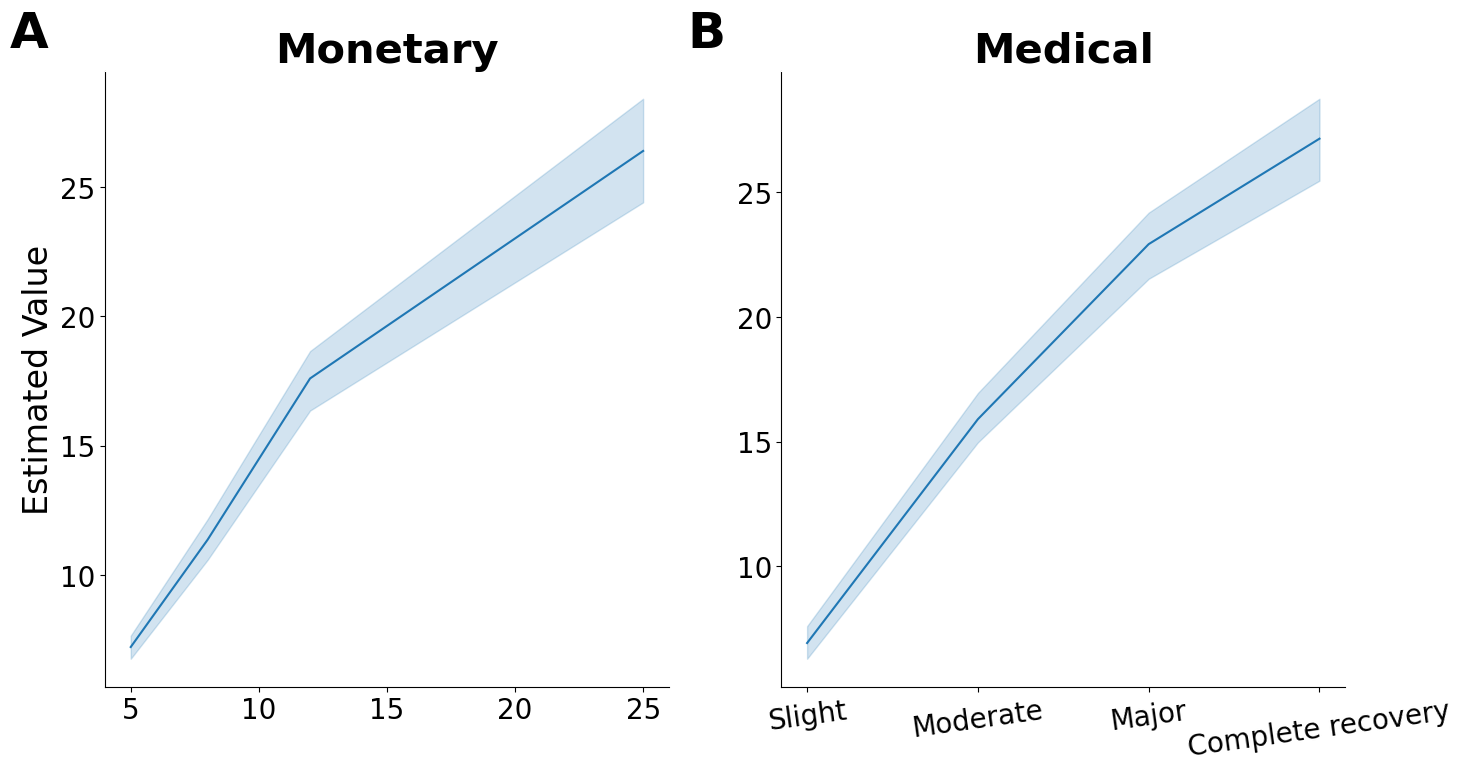

In [20]:
# This will visualize the relationship between different levels and their estimated values for Monetary and Medical contexts.
fig, axes = plt.subplots(1, 2, figsize=(16, 8)) # Initialize a 1x2 subplot layout, with a shared y-axis.


# Plot the estimated value for each level in the 'Monetary' context on the first axis.
sns.lineplot(data=df_long_mon, x='levelName', y='value', ax=axes[0])

# Plot the estimated value for each level in the 'Medical' context on the second axis.
sns.lineplot(data=df_long_med, x='levelName', y='value', ax=axes[1])

# Set the title for each subplot.
axes[0].set_title('Monetary', fontweight="bold", size=30)
axes[1].set_title('Medical', fontweight="bold", size=30)

# Set the y-axis label for the first subplot.
axes[0].set_ylabel('Estimated Value', fontsize=24.0)
axes[1].set_ylabel('', fontsize=24.0)


# Remove x-axis labels as they are self-explanatory with the data points.
axes[0].set_xlabel('', fontsize=24.0)
axes[1].set_xlabel('', fontsize=24.0)

# Adjust the tick parameters to increase font size, ensuring better readability.
axes[0].tick_params(axis='both', which='major', labelsize=20)
axes[1].tick_params(axis='both', which='major', labelsize=20)

# Add a slight rotation to the x-axis tick labels on the second plot for better visualization.
axes[1].tick_params(axis='x', labelrotation=8)

# Set the background color for both plots to white for clarity and aesthetic appeal.
axes[0].set_facecolor('White')
axes[1].set_facecolor('White')

# Remove the right and top spines from both plots to reduce visual clutter.
for spine in ['right', 'top']:
    axes[0].spines[spine].set_color('white')
    axes[1].spines[spine].set_color('white')

subplot_labels = ['A', 'B']

for ax, label in zip(axes.flat, subplot_labels):
    # Position the text at the top left of each subplot
    # Adjust x and y values to change the position of the label
    ax.text(-0.1, 1.1, label, transform=ax.transAxes, fontsize=36, fontweight='bold', va='top', ha='right')

# Adjust the layout to ensure that the plots do not overlap and everything fits well.
#fig.tight_layout()

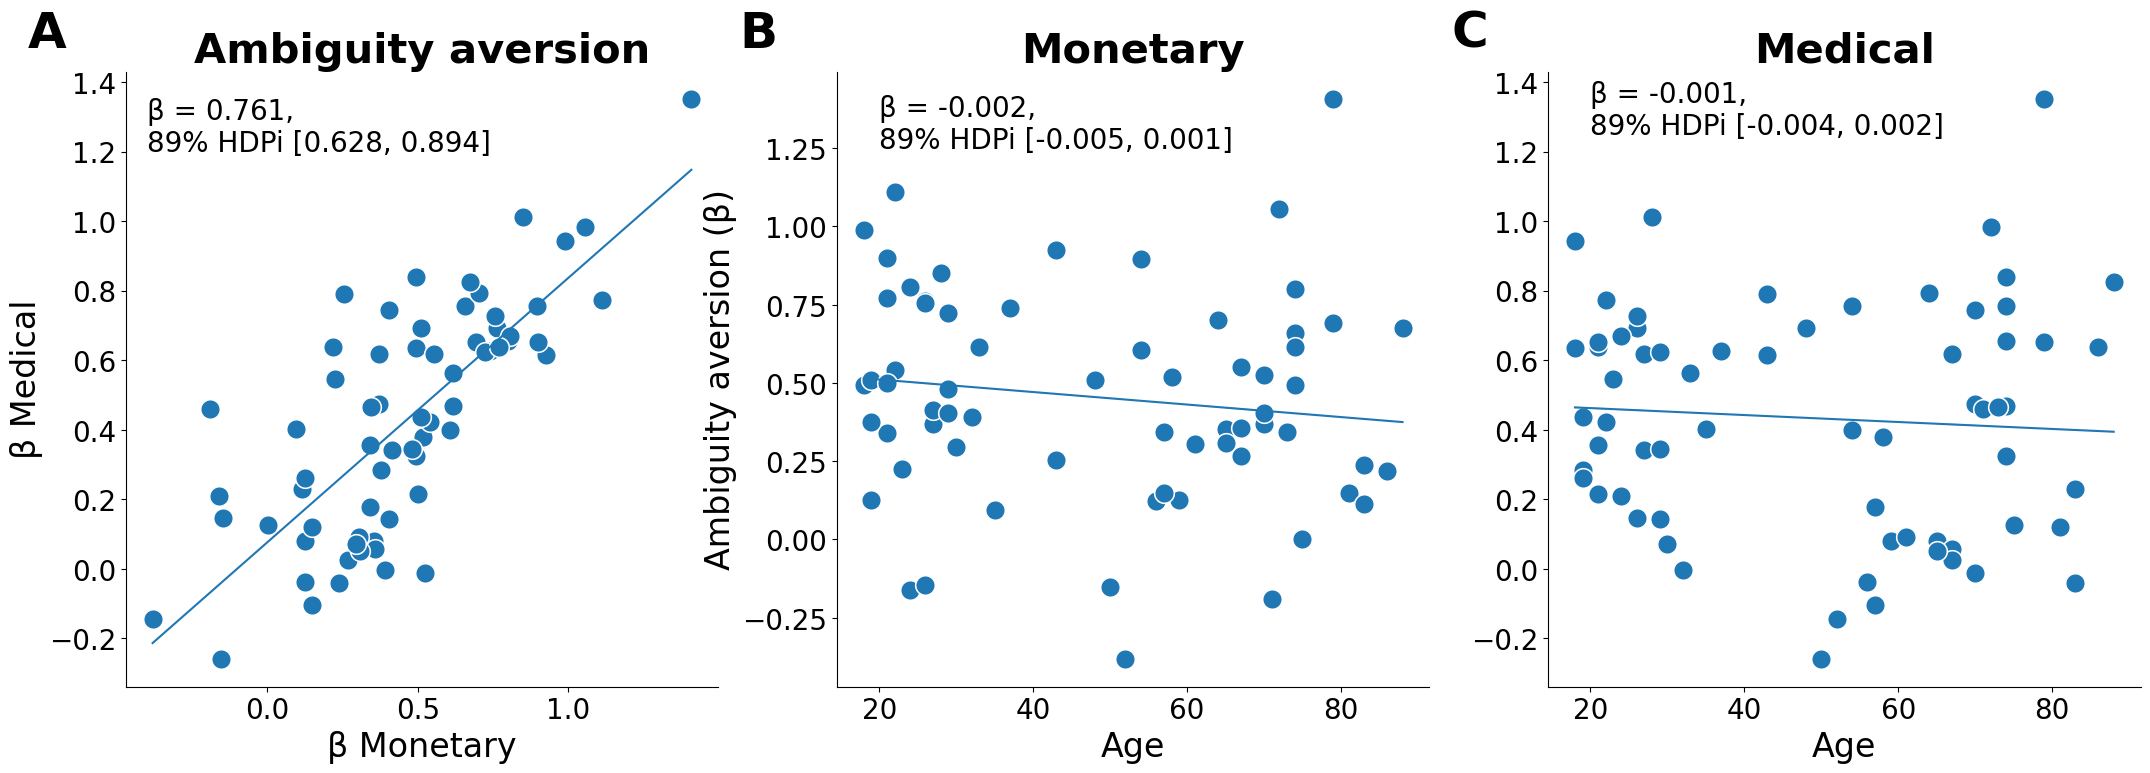

In [22]:
# This will visualize the relationship between different levels and their estimated values for Monetary and Medical contexts.
fig, axes = plt.subplots(1, 3, figsize=(26, 8)) # Initialize a 1x2 subplot layout, with a shared y-axis.

sns.scatterplot(data = df, x = 'amb_est_mon', y = 'amb_est_med', s = 200, ax=axes[0])
sns.lineplot(x = df.amb_est_mon, 
             y = es['mean']['intercept']+es['mean']['slope']*df.amb_est_mon, 
             ax=axes[0])

sns.scatterplot(data = df, x = 'age', y = 'amb_est_mon', s = 200, ax=axes[1])
sns.lineplot(x = df.age, 
             y = agemon['mean']['intercept']+agemon['mean']['slope']*df.age, 
             ax=axes[1])

sns.scatterplot(data = df, x = 'age', y = 'amb_est_med', s = 200, ax=axes[2])
sns.lineplot(x = df.age, 
             y = agemed['mean']['intercept']+agemed['mean']['slope']*df.age, 
             ax=axes[2])


# Set the title for each subplot.
axes[0].set_title('Ambiguity aversion', fontweight="bold", size=30)
axes[1].set_title('Monetary', fontweight="bold", size=30)
axes[2].set_title('Medical', fontweight="bold", size=30)

# Set the y-axis label for the first subplot.
axes[0].set_ylabel('β Medical', fontsize=24.0)
axes[1].set_ylabel('Ambiguity aversion (β)', fontsize=24.0)
axes[2].set_ylabel('', fontsize=24.0)


# Remove x-axis labels as they are self-explanatory with the data points.
axes[0].set_xlabel('β Monetary', fontsize=24.0)
axes[1].set_xlabel('Age', fontsize=24.0)
axes[2].set_xlabel('Age', fontsize=24.0)

# Adjust the tick parameters to increase font size, ensuring better readability.
axes[0].tick_params(axis='both', which='major', labelsize=20)
axes[1].tick_params(axis='both', which='major', labelsize=20)
axes[2].tick_params(axis='both', which='major', labelsize=20)


text = 'β = {:.3f},\n89% HDPi [{:.3f}, {:.3f}]'.format(float(es['mean']['slope']),
                                                       float(es['hdi_5.5%']['slope']),
                                                       float(es['hdi_94.5%']['slope']))
axes[0].text(-.4, 1.2, text, fontsize=20)


text = 'β = {:.3f},\n89% HDPi [{:.3f}, {:.3f}]'.format(float(agemon['mean']['slope']),
                                                       float(agemon['hdi_5.5%']['slope']),
                                                       float(agemon['hdi_94.5%']['slope']))
axes[1].text(20, 1.25, text, fontsize=20)

text = 'β = {:.3f},\n89% HDPi [{:.3f}, {:.3f}]'.format(float(agemed['mean']['slope']),
                                                       float(agemed['hdi_5.5%']['slope']),
                                                       float(agemed['hdi_94.5%']['slope']))
axes[2].text(20, 1.25, text, fontsize=20)

# Set the background color for both plots to white for clarity and aesthetic appeal.
axes[0].set_facecolor('White')
axes[1].set_facecolor('White')
axes[2].set_facecolor('White')

# Remove the right and top spines from both plots to reduce visual clutter.
for spine in ['right', 'top']:
    axes[0].spines[spine].set_color('white')
    axes[1].spines[spine].set_color('white')
    axes[2].spines[spine].set_color('white')
    
    
subplot_labels = ['A', 'B', 'C']

for ax, label in zip(axes.flat, subplot_labels):
    # Position the text at the top left of each subplot
    # Adjust x and y values to change the position of the label
    ax.text(-0.1, 1.1, label, transform=ax.transAxes, fontsize=36, fontweight='bold', va='top', ha='right')


#fig.tight_layout()

In [25]:
mon_simple.to_netcdf('data/mon_simple.nc')
mon_utility.to_netcdf('data/mon_utility.nc')
mon_trmbling_hand.to_netcdf('data/mon_trmbling_hand.nc')
mon_estimated.to_netcdf('data/mon_estimated.nc')
med_simple.to_netcdf('data/med_simple.nc')
med_estimated.to_netcdf('data/med_estimated.nc')

'data/med_estimated.nc'